In [ ]:
import numpy as np

# Column 0 → width in centimeters
# Column 1 → height in centimeters

paintings_wh = np.array([
    [121.3,  82.9],   # Christina's World — Wyeth
    [ 92.1,  73.7],   # The Starry Night — Van Gogh
    [233.7, 243.9],   # Les Demoiselles d’Avignon — Picasso
    [390.1, 259.7],   # Dance (I) — Matisse
    [130.2, 162.3],   # Girl Before a Mirror — Picasso
    [200.7, 250.8],   # The Birth of the World — Miró
])

(6, 2)


In [1]:
# Additional imports needed for image processing
import matplotlib.pyplot as plt
import cv2
import os


## Image Rectification

This notebook rectifies photos of paintings to their correct aspect ratios based on the actual painting dimensions.

**Process:**
1. Load corner points from `painting_corners.npz`
2. Compute target rectangle based on the painting's width/height ratio
3. Compute homography to map from photo coordinates to rectified coordinates
4. Warp the image to the rectified version


In [3]:
def compute_homography(src_points, dst_points):
    """
    Computes the homography matrix H that maps points from src to dst.
    
    Parameters:
    -----------
    src_points : numpy array of shape (N, 2)
        Source points (from the photo)
    dst_points : numpy array of shape (N, 2)
        Destination points (target rectangle)
    
    Returns:
    --------
    H : numpy array of shape (3, 3)
        Homography matrix
    """
    n_points = len(src_points)
    if n_points < 4:
        raise ValueError("At least 4 point correspondences are required")
    
    # Build the A matrix for DLT algorithm
    A = np.zeros((2 * n_points, 9))
    
    for i in range(n_points):
        x1, y1 = src_points[i]
        x2, y2 = dst_points[i]
        
        # First equation
        A[2*i, 0] = x1
        A[2*i, 1] = y1
        A[2*i, 2] = 1
        A[2*i, 3] = 0
        A[2*i, 4] = 0
        A[2*i, 5] = 0
        A[2*i, 6] = -x1 * x2
        A[2*i, 7] = -y1 * x2
        A[2*i, 8] = -x2
        
        # Second equation
        A[2*i+1, 0] = 0
        A[2*i+1, 1] = 0
        A[2*i+1, 2] = 0
        A[2*i+1, 3] = x1
        A[2*i+1, 4] = y1
        A[2*i+1, 5] = 1
        A[2*i+1, 6] = -x1 * y2
        A[2*i+1, 7] = -y1 * y2
        A[2*i+1, 8] = -y2
    
    # Solve using SVD
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    H = H / H[2, 2]  # Normalize
    
    return H


In [4]:
def create_target_rectangle(width_cm, height_cm, target_height=1000):
    """
    Creates a target rectangle with the correct aspect ratio.
    
    Parameters:
    -----------
    width_cm : float
        Width of the painting in centimeters
    height_cm : float
        Height of the painting in centimeters
    target_height : int
        Desired height of the output image in pixels
    
    Returns:
    --------
    corners : numpy array of shape (4, 2)
        Corner points of the target rectangle:
        [top-left, top-right, bottom-right, bottom-left]
    """
    aspect_ratio = width_cm / height_cm
    target_width = int(target_height * aspect_ratio)
    
    corners = np.array([
        [0, 0],                    # Top-left
        [target_width, 0],         # Top-right
        [target_width, target_height],  # Bottom-right
        [0, target_height]         # Bottom-left
    ], dtype=np.float32)
    
    return corners, (target_width, target_height)


In [5]:
def rectify_image(image, src_corners, dst_corners, output_size):
    """
    Rectifies an image using homography transformation.
    
    Parameters:
    -----------
    image : numpy array
        Input image to rectify (RGB format)
    src_corners : numpy array of shape (4, 2)
        Corner points from the photo
    dst_corners : numpy array of shape (4, 2)
        Target corner points (rectified rectangle)
    output_size : tuple (width, height)
        Size of the output rectified image
    
    Returns:
    --------
    rectified : numpy array
        Rectified image (RGB format)
    H : numpy array
        Homography matrix
    """
    # Compute homography
    H = compute_homography(src_corners, dst_corners)
    
    # Convert RGB to BGR for OpenCV
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        image_bgr = image
    
    # Warp the image using OpenCV
    rectified_bgr = cv2.warpPerspective(image_bgr, H, output_size, 
                                        flags=cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT)
    
    # Convert back to RGB
    if len(rectified_bgr.shape) == 3 and rectified_bgr.shape[2] == 3:
        rectified = cv2.cvtColor(rectified_bgr, cv2.COLOR_BGR2RGB)
    else:
        rectified = rectified_bgr
    
    return rectified, H


## Step 1: Load Corner Points

Load the corner points from the saved file.


In [6]:
# Image file names
image_files = [
    'Christinas World — Wyeth.jpeg',
    'The Starry Night — Van Gogh.jpeg',
    'Les Demoiselles dAvignon — Picasso.jpeg',
    'Dance (I) — Matisse.jpeg',
    'Girl Before a Mirror — Picasso.jpeg',
    'The Birth of the World — Miró.jpeg'
]


# Load corner points from saved file
data = np.load('painting_corners.npz')
corner_points = {}
for i in range(6):
    corner_points[i] = data[f'corners_{i}']
print("✓ Loaded corner points from 'painting_corners.npz'")


✓ Loaded corner points from 'painting_corners.npz'


## Step 2: Rectify All Images

Rectify each image to the correct aspect ratio using the loaded corner points.


In [7]:
# Target height for rectified images (in pixels)
# You can adjust this to get higher/lower resolution
TARGET_HEIGHT = 1000

# Process all images
rectified_images = []
homographies = []

for i, img_file in enumerate(image_files):
    print(f"\nProcessing Image {i+1}: {img_file}")
    
    # Load image
    img = plt.imread(img_file)
    
    # Handle different image formats (RGB vs RGBA)
    if img.shape[2] == 4:
        img = img[:, :, :3]  # Remove alpha channel
    
    # Normalize to [0, 255] if needed
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    
    # Get corner points
    src_corners = corner_points[i]
    
    # Create target rectangle based on painting dimensions
    width_cm, height_cm = paintings_wh[i]
    dst_corners, output_size = create_target_rectangle(width_cm, height_cm, TARGET_HEIGHT)
    
    print(f"  Painting size: {width_cm:.1f}cm × {height_cm:.1f}cm")
    print(f"  Aspect ratio: {width_cm/height_cm:.3f}")
    print(f"  Output size: {output_size[0]} × {output_size[1]} pixels")
    
    # Rectify the image
    rectified, H = rectify_image(img, src_corners, dst_corners, output_size)
    rectified_images.append(rectified)
    homographies.append(H)
    
    print(f"  ✓ Rectified successfully")

print(f"\n{'='*70}")
print("All images rectified!")
print(f"{'='*70}")



Processing Image 1: Christinas World — Wyeth.jpeg
  Painting size: 121.3cm × 82.9cm
  Aspect ratio: 1.463
  Output size: 1463 × 1000 pixels
  ✓ Rectified successfully

Processing Image 2: The Starry Night — Van Gogh.jpeg
  Painting size: 92.1cm × 73.7cm
  Aspect ratio: 1.250
  Output size: 1249 × 1000 pixels
  ✓ Rectified successfully

Processing Image 3: Les Demoiselles dAvignon — Picasso.jpeg
  Painting size: 233.7cm × 243.9cm
  Aspect ratio: 0.958
  Output size: 958 × 1000 pixels
  ✓ Rectified successfully

Processing Image 4: Dance (I) — Matisse.jpeg
  Painting size: 390.1cm × 259.7cm
  Aspect ratio: 1.502
  Output size: 1502 × 1000 pixels
  ✓ Rectified successfully

Processing Image 5: Girl Before a Mirror — Picasso.jpeg
  Painting size: 130.2cm × 162.3cm
  Aspect ratio: 0.802
  Output size: 802 × 1000 pixels
  ✓ Rectified successfully

Processing Image 6: The Birth of the World — Miró.jpeg
  Painting size: 200.7cm × 250.8cm
  Aspect ratio: 0.800
  Output size: 800 × 1000 pixels


## Step 3: Visualize Results

Display the original and rectified images side by side.


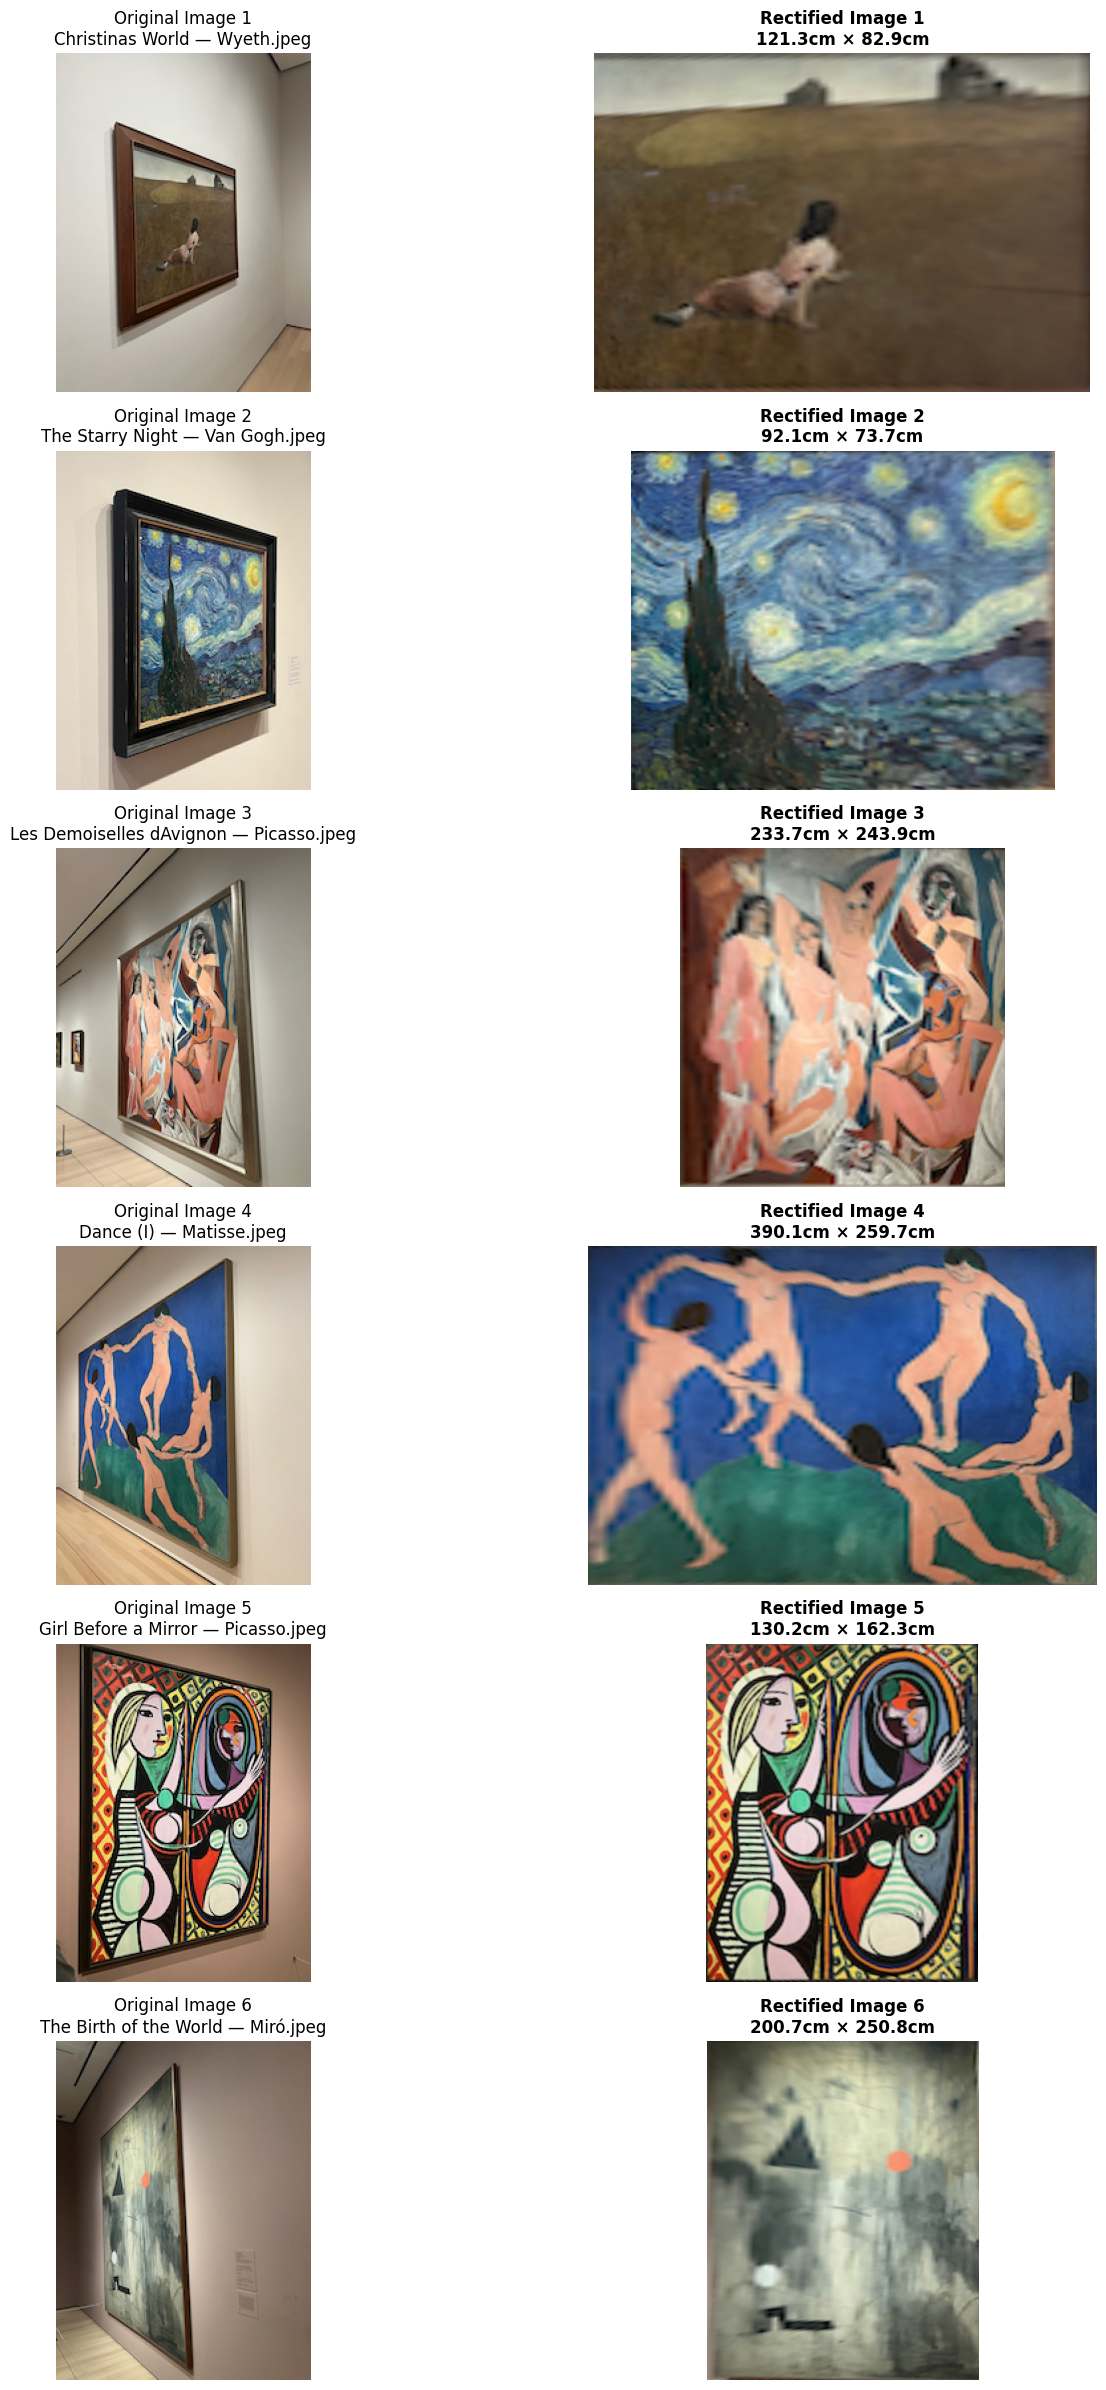

In [8]:
# Display all original and rectified images
fig, axes = plt.subplots(6, 2, figsize=(16, 24))

for i in range(6):
    # Load original image
    img_orig = plt.imread(image_files[i])
    if img_orig.shape[2] == 4:
        img_orig = img_orig[:, :, :3]
    
    # Display original
    axes[i, 0].imshow(img_orig)
    axes[i, 0].set_title(f'Original Image {i+1}\n{image_files[i]}', fontsize=12)
    axes[i, 0].axis('off')
    
    # Display rectified
    axes[i, 1].imshow(rectified_images[i])
    width_cm, height_cm = paintings_wh[i]
    axes[i, 1].set_title(f'Rectified Image {i+1}\n{width_cm:.1f}cm × {height_cm:.1f}cm', 
                        fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Step 4: Save Rectified Images

Save the rectified images to files.


In [11]:
# Save rectified images
output_dir = 'rectified_images'
os.makedirs(output_dir, exist_ok=True)

for i, rectified in enumerate(rectified_images):
    # Get the base name from image_files and create output filename
    base_name = os.path.splitext(image_files[i])[0]  # Get filename without extension
    output_path = os.path.join(output_dir, f'rectified_{base_name}.png')
    # Convert RGB to BGR for OpenCV imwrite (OpenCV expects BGR)
    if len(rectified.shape) == 3 and rectified.shape[2] == 3:
        rectified_bgr = cv2.cvtColor(rectified, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, rectified_bgr)
    else:
        cv2.imwrite(output_path, rectified)
    print(f"Saved: {output_path}")

print(f"\n✓ All rectified images saved to '{output_dir}/' directory")


Saved: rectified_images/rectified_Christinas World — Wyeth.png
Saved: rectified_images/rectified_The Starry Night — Van Gogh.png
Saved: rectified_images/rectified_Les Demoiselles dAvignon — Picasso.png
Saved: rectified_images/rectified_Dance (I) — Matisse.png
Saved: rectified_images/rectified_Girl Before a Mirror — Picasso.png
Saved: rectified_images/rectified_The Birth of the World — Miró.png

✓ All rectified images saved to 'rectified_images/' directory
